# Cancer detection using Visual Models

This is a sample notebook, exploring building a machine-learning pipeline for the task of binary classification of cancer patients using  the dataset of 7909 breast cancer histopathology images acquired on 82 patients, which is now publicly available from http://web.inf.ufpr.br/vri/breast-cancer-database. DOI: 10.1109/TBME.2015.2496264

A bit deeper about the dataset: 

The data provided for classification consists of histopathological images—specifically, glass slide microscope images of lymph nodes stained with hematoxylin and eosin (H&E). H&E staining is the most widely used technique in histology, helping to localize cell nuclei and extracellular proteins. In this process, hematoxylin undergoes an oxidation reaction with nuclear histones, resulting in blue-stained nuclei, while the cytoplasm and extracellular structures typically appear in shades of pink. Lymph nodes are small glands that filter fluid in the lymphatic system and are often the first location to which breast cancer spreads. Assessing lymph node metastases histologically is an important step in determining the stage of breast cancer according to the TNM classification—a globally recognized system for evaluating cancer spread.

## 1. Small EDA: Let's explore the data

In [1]:
from MammoNet.dataset.data_handler import DataHandler
from MammoNet.dataset.dataset import HistologyDataset

data_handler = DataHandler()
my_data = data_handler.read_full_dataset()
paths, labels, sublabels, resolutions = my_data
explore_dataset = HistologyDataset(paths, labels)

c:\Users\ismyn\miniconda3\envs\mammonet_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ismyn\miniconda3\envs\mammonet_env\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Let's explore the distributoons of data

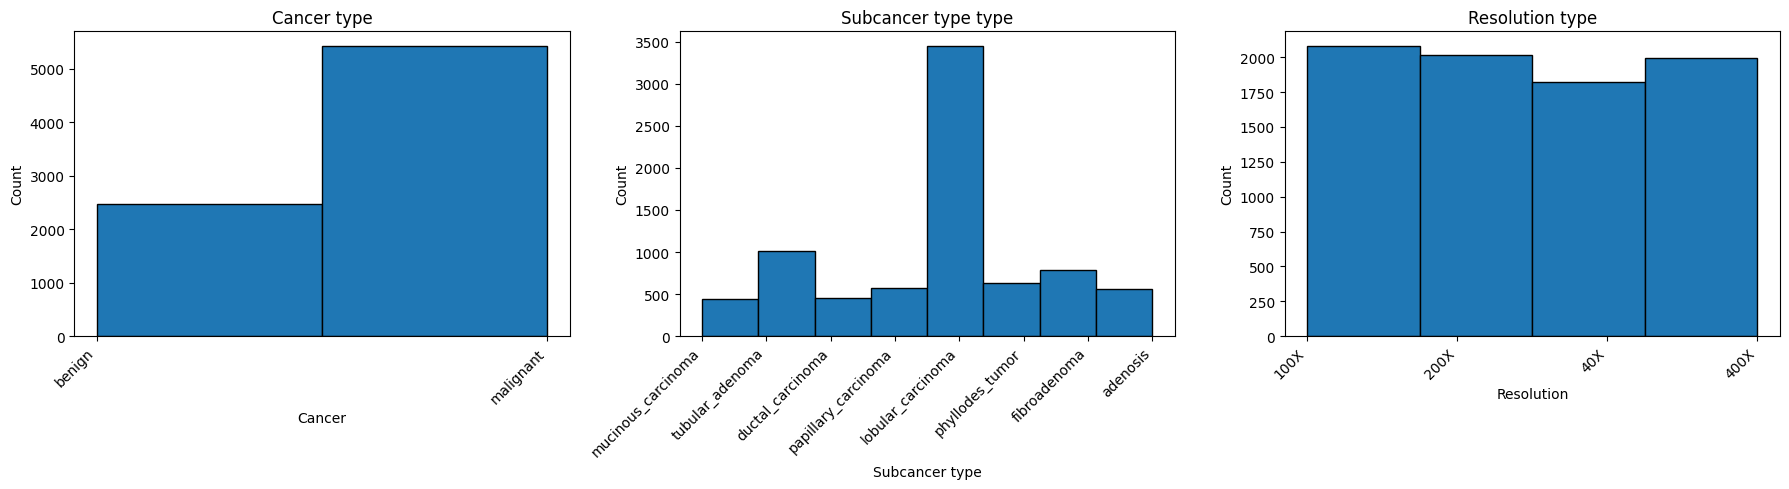

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, data, name in zip(axes, [labels, sublabels, resolutions], ['Cancer', 'Subcancer type', 'Resolution']):
    ax.hist(data, bins=len(set(data)), edgecolor='black')
    ax.set_title(f"{name} type")
    ax.set_xlabel(name)
    ax.set_ylabel('Count')
    ax.set_xticks(range(len(set(data))))
    ax.set_xticklabels(set(data), rotation=45, ha='right')

plt.tight_layout()
plt.show()

Now, let's plot per cancer type: **Malignant vs Benign**

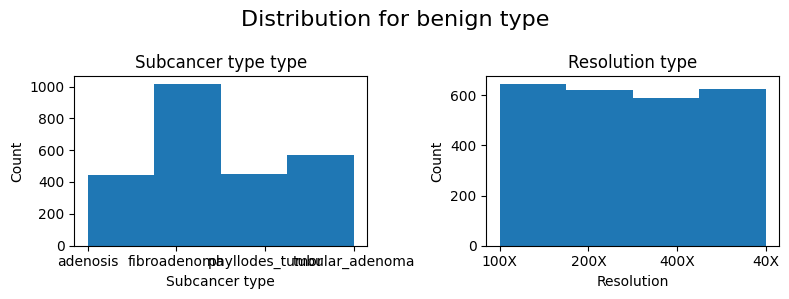

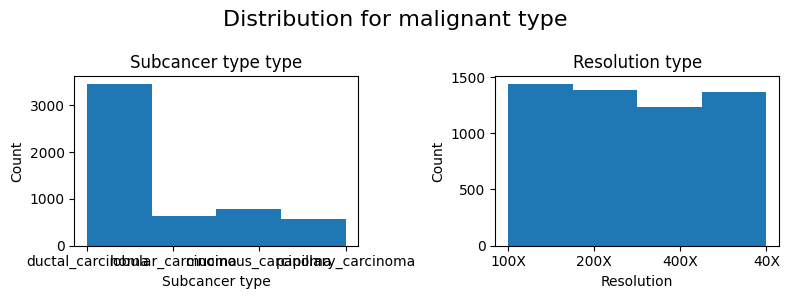

In [3]:
for cancer_type in ['benign', 'malignant']:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    mask = [label == cancer_type for label in labels]
    fig.suptitle(f"Distribution for {cancer_type} type", fontsize=16)
    for ax, data, name in zip(axes, [sublabels, resolutions], ['Subcancer type', 'Resolution']):
        col = 'pink' if cancer_type == 'benign' else 'blue'
        filtered_data = [d for d, m in zip(data, mask) if m]
        ax.hist(filtered_data, bins=len(set(filtered_data)))
        ax.set_title(f"{name} type")
        ax.set_xlabel(name)
        ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

Distributions of beningn and malicious cancers vary quite a bit if we look at particular cancer type.

# TODO: make augmentations of data

## Let's train a model!

In [4]:
data_handler = DataHandler()
train_loader, val_loader, test_loader = data_handler.get_dataset_loaders()

In [5]:
from MammoNet.models.SimpleCNN import SimpleCNN

In [ ]:
model = SimpleCNN()
model.train(train_loader, val_loader, test_loader)

Training Batch: 100%|██████████| 75/75 [00:52<00:00,  1.42it/s]


Epoch [1/5], Train Loss: 0.8335, Val Loss: 0.5527, Val Accuracy: 0.7069,Test Loss: 0.5531, Test Accuracy: 0.7068


Training Batch:  80%|████████  | 60/75 [00:48<00:12,  1.19it/s]

Next steps: 

- Vit,
- Cnn backbone
- Integrate wandb!